# Uncertainty quantiles

__Test__

Create three versions of the prediction model, one for each of the 5%, 50% and 95% quantiles. Use the 5% and 95% results to get a plus/minus value for the predicted value.

Based on this paper on quantile regression for XGBoost: https://arxiv.org/pdf/2304.11732.pdf
Have to switch the loss function to one that has a second derivative at zero, in this case the Huber loss function.

Most of the setup for this notebook is copied directly from notebook 01 that creates the normal predictor and SHAP models.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import pickle

from dataclasses import dataclass
from xgboost import XGBClassifier, XGBRegressor

/home/anna/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/anna/miniconda3/envs/sam10/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizat

In [2]:
import stroke_utilities.process_data as process_data
import stroke_utilities.models as models
import stroke_utilities.scenario as scenario

## Set up paths and filenames

In [3]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data_read_path: str = './stroke_utilities/data/'
    output_folder = './stroke_utilities/output/'
    model_folder = './stroke_utilities/models'
    model_text = 'lgbm_decision_'
    notebook: str = '01_'

paths = Paths()

## Load data

Import the data from file:

In [4]:
# Load data
train = pd.read_csv(paths.data_read_path + 'cohort_10000_train.csv')
train['stroke_team_id'] = train['stroke_team_id'].astype('category')
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

## Process data

Restrict the data to the following ten features, plus the "thrombolysis" feature.

In [5]:
# Put data into the format for model
features_to_model = [
    'stroke_team_id',
    'stroke_severity',
    'prior_disability',
    'age',
    'infarction',
    'onset_to_arrival_time',
    'precise_onset_known',
    'onset_during_sleep',
    'arrival_to_scan_time',
    'afib_anticoagulant',
    # 'year',    
    'thrombolysis'
]

In [6]:
train = train[features_to_model]
test = test[features_to_model]

In [7]:
stroke_team_ids = train.sort_values('stroke_team_id')['stroke_team_id'].unique().to_list()

In [8]:
teams = []
team_lengths = []

for stroke_team_id in stroke_team_ids:
    teams.append(stroke_team_id)
    team_lengths.append(len(train[train['stroke_team_id'] == stroke_team_id]))

In [9]:
df = pd.DataFrame(np.array([teams, team_lengths]).T, columns=['teams', 'team_lengths'])

In [10]:
df = df.sort_values('team_lengths')

df['rank_size'] = np.arange(len(df))

df

,teams,team_lengths,rank_size
84,85,92,0
94,95,109,1
108,109,209,2
101,102,216,3
62,63,291,4
...,...,...,...
70,71,1596,114
98,99,1629,115
69,70,1662,116
5,6,1802,117


In [11]:
df[df['teams'] == 33]

,teams,team_lengths,rank_size
32,33,757,39


If the year of admission to stroke team is still in the data, restrict it to the following range.

Currently this process does nothing because we have already removed "year" from the data.

In [12]:
train = process_data.restrict_data_to_range(train, 2016, 2018, 'year')
test = process_data.restrict_data_to_range(test, 2016, 2018, 'year')

Split the data. X contains the features for the model to use to predict use of thrombolysis, and y contains whether thrombolysis was used in the real data.

In [13]:
X_train, y_train = process_data.split_X_and_y(train, 'thrombolysis')
X_test, y_test = process_data.split_X_and_y(test, 'thrombolysis')

Check the list of features currently included in the X data:

In [14]:
features = list(X_train)

features

['stroke_team_id',
 'stroke_severity',
 'prior_disability',
 'age',
 'infarction',
 'onset_to_arrival_time',
 'precise_onset_known',
 'onset_during_sleep',
 'arrival_to_scan_time',
 'afib_anticoagulant']

For the XGBoost model, we need to change the single "stroke team ID" column to many individual team columns. For 119 separate teams, we will create 119 new columns. Each column may contain either 1 (meaning "yes") where a patient attended that stroke team, or 0 (meaning "no") where the patient did not attend that stroke team.

In [15]:
X_train = process_data.one_hot_encode_column(
    X_train, 'stroke_team_id', prefix='team')

X_test = process_data.one_hot_encode_column(
    X_test, 'stroke_team_id', prefix='team')

Check that the "stroke_team_id" column has gone and that there are now many "team_" columns.

In [16]:
# Get features
features_ohe = list(X_train)

# Print the first several...
print(features_ohe[:15])
# ... and last few feature names:
print(features_ohe[-3:])
# The remaining features are all "team_X" for increasing X.

['stroke_severity', 'prior_disability', 'age', 'infarction', 'onset_to_arrival_time', 'precise_onset_known', 'onset_during_sleep', 'arrival_to_scan_time', 'afib_anticoagulant', 'team_1', 'team_2', 'team_3', 'team_4', 'team_5', 'team_6']
['team_117', 'team_118', 'team_119']


## Split data further for two training sets

Halve the existing training data. The first half is for training the classification model as normal. The second half is for training the quantile regression models.

In [17]:
i = int(0.5*len(X_train))

X_train1 = X_train[:i]
y_train1 = y_train[:i]

X_test1 = X_train[i:]
y_test1 = y_train[i:]

In [18]:
X_train2 = X_test1
# y_train2 = results from predict_proba

X_test2 = X_test
# y_test2 = results from predict_proba

## Fit models

### Model 1

Use an XGBoost model and teach it to predict the use of thrombolysis by using the training data set:

In [19]:
# Define and Fit model
# Original model:
model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)
model.fit(X_train1, y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [20]:
# Get predictions
predicted_test1 = model.predict(X_test1)
predicted_proba_test1 = model.predict_proba(X_test1)[:,1]

# Show overall accuracy
accuracy_test1 = np.mean(predicted_test1 == y_test1)
print (f'Accuracy: {accuracy_test1:.3f}')

Accuracy: 0.827


In [21]:
# Get predictions
predicted_test2 = model.predict(X_test2)
predicted_proba_test2 = model.predict_proba(X_test2)[:,1]

# Show overall accuracy
accuracy_test1 = np.mean(predicted_test2 == y_test)
print (f'Accuracy: {accuracy_test1:.3f}')

Accuracy: 0.822


### Update prediction column for second data set

In [22]:
y_train2 = predicted_proba_test1

In [23]:
y_test2 = predicted_proba_test2

## Models 2

In [45]:
# New model from scratch, now regression to match the predict_proba from the first go round.

# Quantiles at 5%, 50%, 95%.
model2 = XGBRegressor(
    verbosity = 0, seed=42, learning_rate=0.5,
    objective='reg:quantileerror',
    quantile_alpha=[0.05, 0.50, 0.95],
    # tree_method='hist',
    # max_depth=5
)
model2.fit(X_train2, y_train2)

# Get predictions
predicted_test2 = model2.predict(X_test2)

In [46]:
predicted_test2_05 = predicted_test2[:, 0]
predicted_test2_50 = predicted_test2[:, 1]
predicted_test2_95 = predicted_test2[:, 2]

In [47]:
# Size of the error bar below each point:
# (NOT the y-value of the tip of the bar)
yerr_low = predicted_test2_50 - predicted_test2_05
yerr_low[yerr_low < 0] = 0.0

# Size of the error bar above each point:
yerr_high = predicted_test2_95 - predicted_test2_50
yerr_high[yerr_high < 0] = 0.0

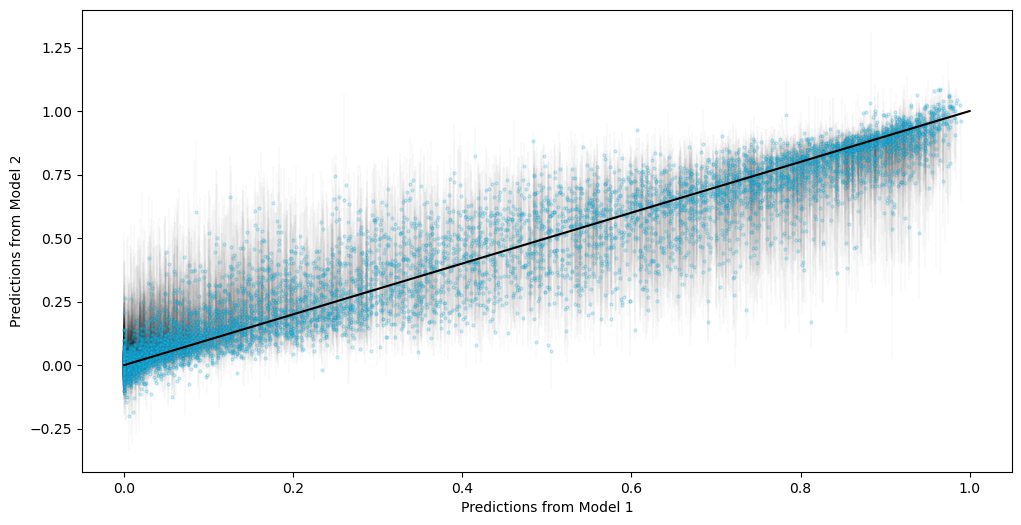

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.errorbar(
    y_test2, predicted_test2_50, 
    yerr=np.array([yerr_low, yerr_high]),
    marker='o',
    markerfacecolor=(0, 1, 1, 0.2),
    markersize=2, linestyle='', ecolor=(0, 0, 0, 0.02))
ax.plot([0, 1], [0, 1], color='k', zorder=4)
# ax.set_aspect('equal')
ax.set_xlabel('Predictions from Model 1')
ax.set_ylabel('Predictions from Model 2')
plt.show()

(array([2.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 5.000e+00,
        1.000e+01, 1.200e+01, 1.600e+01, 2.300e+01, 2.500e+01, 3.900e+01,
        5.500e+01, 7.300e+01, 1.020e+02, 1.170e+02, 1.630e+02, 2.310e+02,
        2.790e+02, 4.120e+02, 6.430e+02, 1.169e+03, 2.443e+03, 1.594e+03,
        7.860e+02, 5.320e+02, 3.650e+02, 2.060e+02, 1.740e+02, 1.360e+02,
        1.120e+02, 7.300e+01, 4.600e+01, 3.900e+01, 2.600e+01, 2.500e+01,
        1.600e+01, 1.500e+01, 9.000e+00, 9.000e+00, 3.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.5355019 , -0.51192451, -0.48834714, -0.46476975, -0.44119236,
        -0.417615  , -0.3940376 , -0.37046021, -0.34688285, -0.32330546,
        -0.29972807, -0.2761507 , -0.25257331, -0.22899592, -0.20541854,
        -0.18184116, -0.15826377, -0.1346864 , -0.11110901, -0.08753163,
        -0.06395425, -0.04037686, -0.01679948,  0.0067779 ,  0.03035528,
         0.

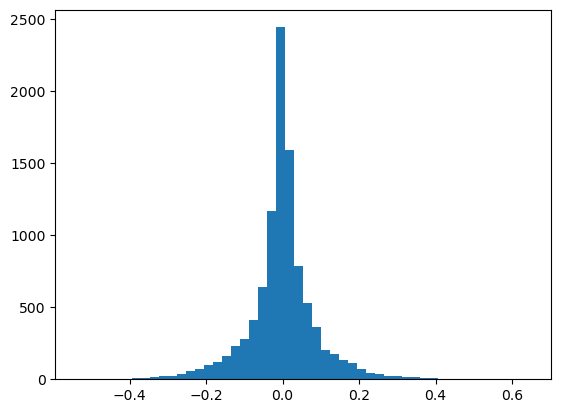

In [49]:
plt.hist(y_test2 - predicted_test2_50, bins=50)

In [50]:
ybar_height = predicted_test2_95 - predicted_test2_05

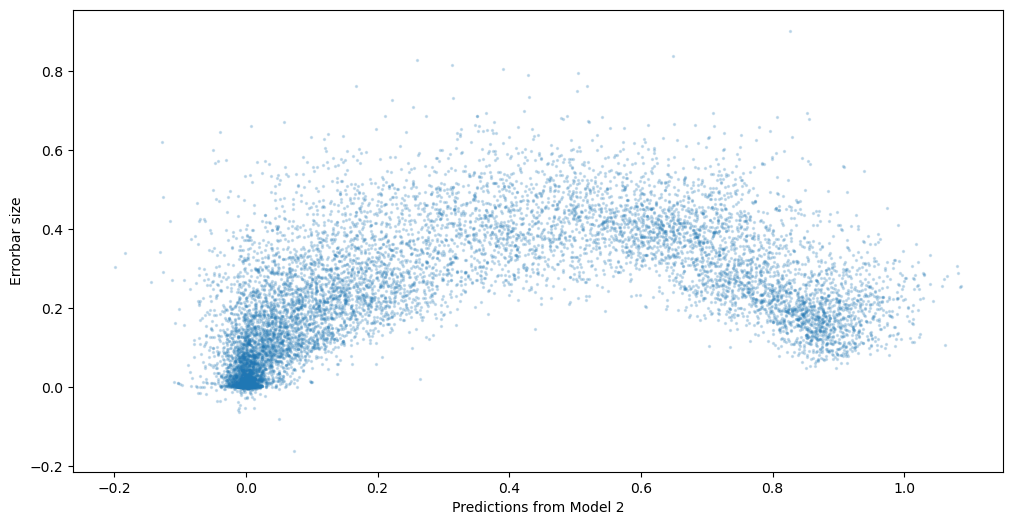

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(predicted_test2_50, ybar_height, s=2, alpha=0.2)
ax.set_xlabel('Predictions from Model 2')
ax.set_ylabel('Errorbar size')
plt.show()

### When do the results not make sense?

Mostly when the predicted probability is near 0 or 1.

(array([  3.,  27., 351.,  64.,  43.,  25.,   6.,   5.,   6.,   1.,   3.,
          1.,   0.,   4.,   4.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   1.,   0.,   3.,   2.,   6.,   7.,  15.,  17.,
         15.,  17.,  10.,   6.,   2.,   2.]),
 array([-4.47119102e-02, -2.21046843e-02,  5.02541079e-04,  2.31097676e-02,
         4.57169935e-02,  6.83242157e-02,  9.09314454e-02,  1.13538668e-01,
         1.36145890e-01,  1.58753127e-01,  1.81360349e-01,  2.03967571e-01,
         2.26574793e-01,  2.49182016e-01,  2.71789253e-01,  2.94396460e-01,
         3.17003697e-01,  3.39610934e-01,  3.62218142e-01,  3.84825379e-01,
         4.07432616e-01,  4.30039823e-01,  4.52647060e-01,  4.75254267e-01,
         4.97861505e-01,  5.20468712e-01,  5.43075979e-01,  5.65683186e-01,
         5.88290393e-01,  6.10897660e-01,  6.33504868e-01,  6.56112075e-01,
         6.78719282e-01,  7.01326549e-01,  7.23933

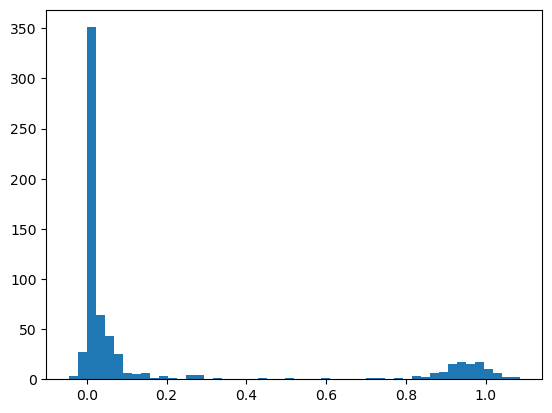

In [54]:
plt.hist(predicted_test2_50[np.where(predicted_test2_95 < predicted_test2_50)], bins=50)

(array([  2.,   0.,   1.,   3.,   8.,  12.,  43.,  75., 275., 342.,  50.,
         30.,  20.,  10.,   9.,   4.,   4.,   1.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.19842839, -0.17752323, -0.15661804, -0.13571288, -0.1148077 ,
        -0.09390253, -0.07299735, -0.05209218, -0.03118701, -0.01028184,
         0.01062334,  0.03152851,  0.05243368,  0.07333885,  0.09424403,
         0.1151492 ,  0.13605437,  0.15695955,  0.17786472,  0.1987699 ,
         0.21967506,  0.24058023,  0.2614854 ,  0.28239059,  0.30329576,
         0.32420093,  0.3451061 ,  0.36601126,  0.38691646,  0.40782163,
         0.42872679,  0.44963196,  0.47053713,  0.49144232,  0.51234746,
         0.53325266,  0.55415785,  0.57506299,  0.59596819,  0.61687332,
         0.63777852,  0.65868372,  0.67958885,  0.70049405,  0.72139919,
 

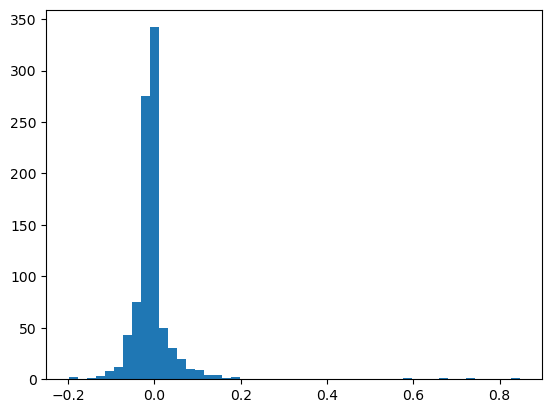

In [55]:
plt.hist(predicted_test2_50[np.where(predicted_test2_50 < predicted_test2_05)], bins=50)